## Найдем токсичные комментарии и отправим их на модерацию

### Оглавление

[1. Знакомство с данными и их подготовка](#section1)\
[2. Обучение разных моделей](#section2)\
[3. Анализ скорости работы и качества моделей](#section3)\
[4. Общий вывод](#section4)

<a id='section1'></a>
### 1. Закомство с данными и их подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from nltk.stem.snowball import SnowballStemmer
from datetime import datetime
import lightgbm as lgb

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('F:/DS/Задачи Практикум/Projects/3 блок/ML для текстов/toxic_comments.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [5]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Text(0.5, 1.0, 'Баланс классов')

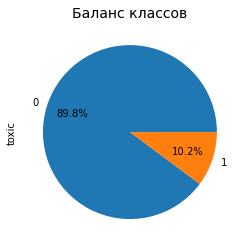

In [6]:
df_pie = df.groupby("toxic")["toxic"].count()
pie, ax = plt.subplots(figsize=[8,4])
df_pie.plot.pie(autopct="%.1f%%", pctdistance=0.7)
plt.title("Баланс классов", fontsize=14)

Как видим, у наших данных сильный дисбаланс классов. Посмотрим, мб это понадобится учесть.

In [7]:
stemmer = SnowballStemmer("english")
def clean_stem(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([stemmer.stem(word) for word in word_list])
    return lemmatized_output

In [8]:
df_clean = pd.DataFrame(df['text'].apply(clean_stem))
df_clean['toxic'] = df['toxic']

Разделим датасет на тренировочную и тестовую выборку.

In [9]:
train, test = train_test_split(df_clean, test_size = 0.3, random_state = 123)

Сделаем из наших твитов обучающий и тестовый корпусы.

In [10]:
corpus_train = list(train['text'])
corpus_test = list(test['text'])

Стеммингуем и уберем стоп-слова.

Преобразуем наши корпусы в матрицы TF-IDF.

In [11]:
count_tf_idf = TfidfVectorizer()
tf_idf_train = count_tf_idf.fit_transform(corpus_train)
tf_idf_test = count_tf_idf.transform(corpus_test)

<a id='section2'></a>
### 2. Обучение разных моделей

#### Логистическая регрессия

In [12]:
start_time = datetime.now()
modelLogR = LogisticRegression(random_state = 123)
modelLogR.fit(tf_idf_train, train['toxic'])
end_time = datetime.now()
duration = end_time - start_time

In [13]:
start_time = datetime.now()
predictions_LogR = modelLogR.predict(tf_idf_test)
end_time = datetime.now()
duration_pred = end_time - start_time

In [14]:
f1_LogR = (f1_score(test['toxic'], predictions_LogR)).round(2)

In [15]:
#Начнем формировать таблицу для сравнения скора и скорости обучения моделей
metrics = pd.DataFrame([[f1_LogR, duration, duration_pred]], columns = ['f1', 'training_time_sec', 'predict_time_sec'],
                       index = ['LogRegression'])
metrics

,f1,training_time_sec,predict_time_sec
LogRegression,0.75,00:00:06.437486,00:00:00.012791


#### LightGBM

In [16]:
start_time = datetime.now()
model_lgbm = lgb.LGBMClassifier(random_state = 123)
model_lgbm.fit(tf_idf_train, train['toxic'])
end_time = datetime.now()
duration = end_time - start_time

In [17]:
start_time = datetime.now()
predictions_lgbm = model_lgbm.predict(tf_idf_test)
end_time = datetime.now()
duration_pred = end_time - start_time

In [18]:
f1_lgbm = (f1_score(test['toxic'], predictions_lgbm)).round(2)

In [19]:
metrics = metrics.append(pd.DataFrame([[f1_lgbm, duration, duration_pred]], 
                                      columns = ['f1', 'training_time_sec', 'predict_time_sec'],
                                      index = ['LightGBM']))
metrics

,f1,training_time_sec,predict_time_sec
LogRegression,0.75,00:00:06.437486,00:00:00.012791
LightGBM,0.77,00:01:24.150410,00:00:00.552524


#### CatBoost

In [20]:
start_time = datetime.now()
model_cat = CatBoostClassifier(eval_metric = 'F1', verbose=100, learning_rate = 0.4, random_state = 123)
model_cat.fit(tf_idf_train, train['toxic'])
end_time = datetime.now()
duration = end_time - start_time

0:	learn: 0.3728240	total: 1.69s	remaining: 28m 5s
100:	learn: 0.7884383	total: 1m 37s	remaining: 14m 26s
200:	learn: 0.8248394	total: 3m 7s	remaining: 12m 26s
300:	learn: 0.8431401	total: 4m 49s	remaining: 11m 12s
400:	learn: 0.8477013	total: 6m 18s	remaining: 9m 25s
500:	learn: 0.8544782	total: 7m 49s	remaining: 7m 47s
600:	learn: 0.8634757	total: 9m 20s	remaining: 6m 12s
700:	learn: 0.8725737	total: 10m 54s	remaining: 4m 38s
800:	learn: 0.8800568	total: 12m 18s	remaining: 3m 3s
900:	learn: 0.8899535	total: 13m 38s	remaining: 1m 29s
999:	learn: 0.9062093	total: 14m 59s	remaining: 0us


In [21]:
start_time = datetime.now()
predictions_cat = model_cat.predict(tf_idf_test)
end_time = datetime.now()
duration_pred = end_time - start_time

In [22]:
f1_CatB = (f1_score(test['toxic'], predictions_cat)).round(2)

In [23]:
metrics = metrics.append(pd.DataFrame([[f1_CatB, duration, duration_pred]], 
                                      columns = ['f1', 'training_time_sec', 'predict_time_sec'],
                                      index = ['CatBoost']))
metrics

,f1,training_time_sec,predict_time_sec
LogRegression,0.75,00:00:06.437486,00:00:00.012791
LightGBM,0.77,00:01:24.150410,00:00:00.552524
CatBoost,0.79,00:15:01.120195,00:00:01.330420


<a id='section3'></a>
### 3. Анализ скорости работы и качества моделей

In [24]:
metrics

,f1,training_time_sec,predict_time_sec
LogRegression,0.75,00:00:06.437486,00:00:00.012791
LightGBM,0.77,00:01:24.150410,00:00:00.552524
CatBoost,0.79,00:15:01.120195,00:00:01.330420


Как видим, лучшее качество у CatBoost, но он медленный. LightGBM быстрее, но с чуть худшим качеством.\
Интересно, что модели справились с данными без параметра "балансирование классов".\
Когда вводила этот параметр, качество ухудшалось.

<a id='section4'></a>
### 4. Общий вывод

В данной работе мы перевели текстовые данные в векторы (числа):
- убрали стоп-слова и лишние символы
- токенизировали текст
- использовали стемминг (выделение корней слов)
- перекодировали все в числа методом tf-idf

Затем обучили машину на векторных данных как обычно.\
Несмотря на сильный дисбаланс классов, мы получили лучшее качество на катбусте: f1 = 0.79.\
Однако, при этом, это самый затратный по ресурсам вариант.\
Если ресурсозатратность имеет большое значение, то лучше выбрать LightGBM с f1 = 0.77.\
При загрузке текcтов в нашу модель, она будет предсказывать: токсичный текст или нет.